In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('rossmann_analysis.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [3]:
# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

logger.info("Starting Rossmann Sales Forecasting Analysis")

2025-06-24 13:23:28,021 - INFO - Starting Rossmann Sales Forecasting Analysis


In [5]:
# Load data
logger.info("Loading data files...")
train_df = pd.read_csv('rossmann-store-sales/train.csv')
test_df = pd.read_csv('rossmann-store-sales/test.csv')
store_df = pd.read_csv('rossmann-store-sales/store.csv')


2025-06-24 13:23:56,745 - INFO - Loading data files...


In [7]:
# Basic data information
logger.info("Data loaded successfully")
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("Store dataset shape:", store_df.shape)

2025-06-24 13:24:56,603 - INFO - Data loaded successfully


Train dataset shape: (1017209, 9)
Test dataset shape: (41088, 8)
Store dataset shape: (1115, 10)


In [13]:
# Data overview
print("\n=== TRAIN DATASET INFO ===")
print(train_df.info())
print("\n=== STORE DATASET INFO ===")
print(store_df.info())
print("\n=== TEST DATASET INFO ===")
print(test_df.info())


=== TRAIN DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

=== STORE DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   S

In [15]:
# Check for missing values
print("\n=== MISSING VALUES ===")
print("Train dataset missing values:")
print(train_df.isnull().sum())
print("\nStore dataset missing values:")
print(store_df.isnull().sum())
print("\nTest dataset missing values:")
print(test_df.isnull().sum())


=== MISSING VALUES ===
Train dataset missing values:
Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store dataset missing values:
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Test dataset missing values:
Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


In [17]:
# Merge train and store data
logger.info("Merging train and store datasets")
train_merged = pd.merge(train_df, store_df, on='Store', how='left')
test_merged = pd.merge(test_df, store_df, on='Store', how='left')

2025-06-24 13:32:02,079 - INFO - Merging train and store datasets


In [19]:
# Convert Date column to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])

# Extract date features
logger.info("Extracting date features")
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Day'] = train_merged['Date'].dt.day
train_merged['DayOfWeek'] = train_merged['Date'].dt.dayofweek
train_merged['WeekOfYear'] = train_merged['Date'].dt.isocalendar().week

2025-06-24 13:32:23,845 - INFO - Extracting date features


In [21]:
# Data Cleaning
logger.info("Starting data cleaning process")

# Handle missing values
train_merged['CompetitionDistance'].fillna(train_merged['CompetitionDistance'].median(), inplace=True)
train_merged['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
train_merged['CompetitionOpenSinceYear'].fillna(0, inplace=True)
train_merged['Promo2SinceWeek'].fillna(0, inplace=True)
train_merged['Promo2SinceYear'].fillna(0, inplace=True)
train_merged['PromoInterval'].fillna('None', inplace=True)

2025-06-24 13:32:49,868 - INFO - Starting data cleaning process


In [23]:
# Remove outliers (sales = 0 when store is open)
logger.info("Removing outliers")
initial_rows = len(train_merged)
train_merged = train_merged[~((train_merged['Sales'] == 0) & (train_merged['Open'] == 1))]
logger.info(f"Removed {initial_rows - len(train_merged)} outlier rows")

2025-06-24 13:33:07,095 - INFO - Removing outliers
2025-06-24 13:33:07,384 - INFO - Removed 54 outlier rows


In [25]:
print("Train dataset shape:", train_merged.shape)

Train dataset shape: (1017155, 22)


2025-06-24 13:36:00,701 - INFO - Analyzing promotions distribution


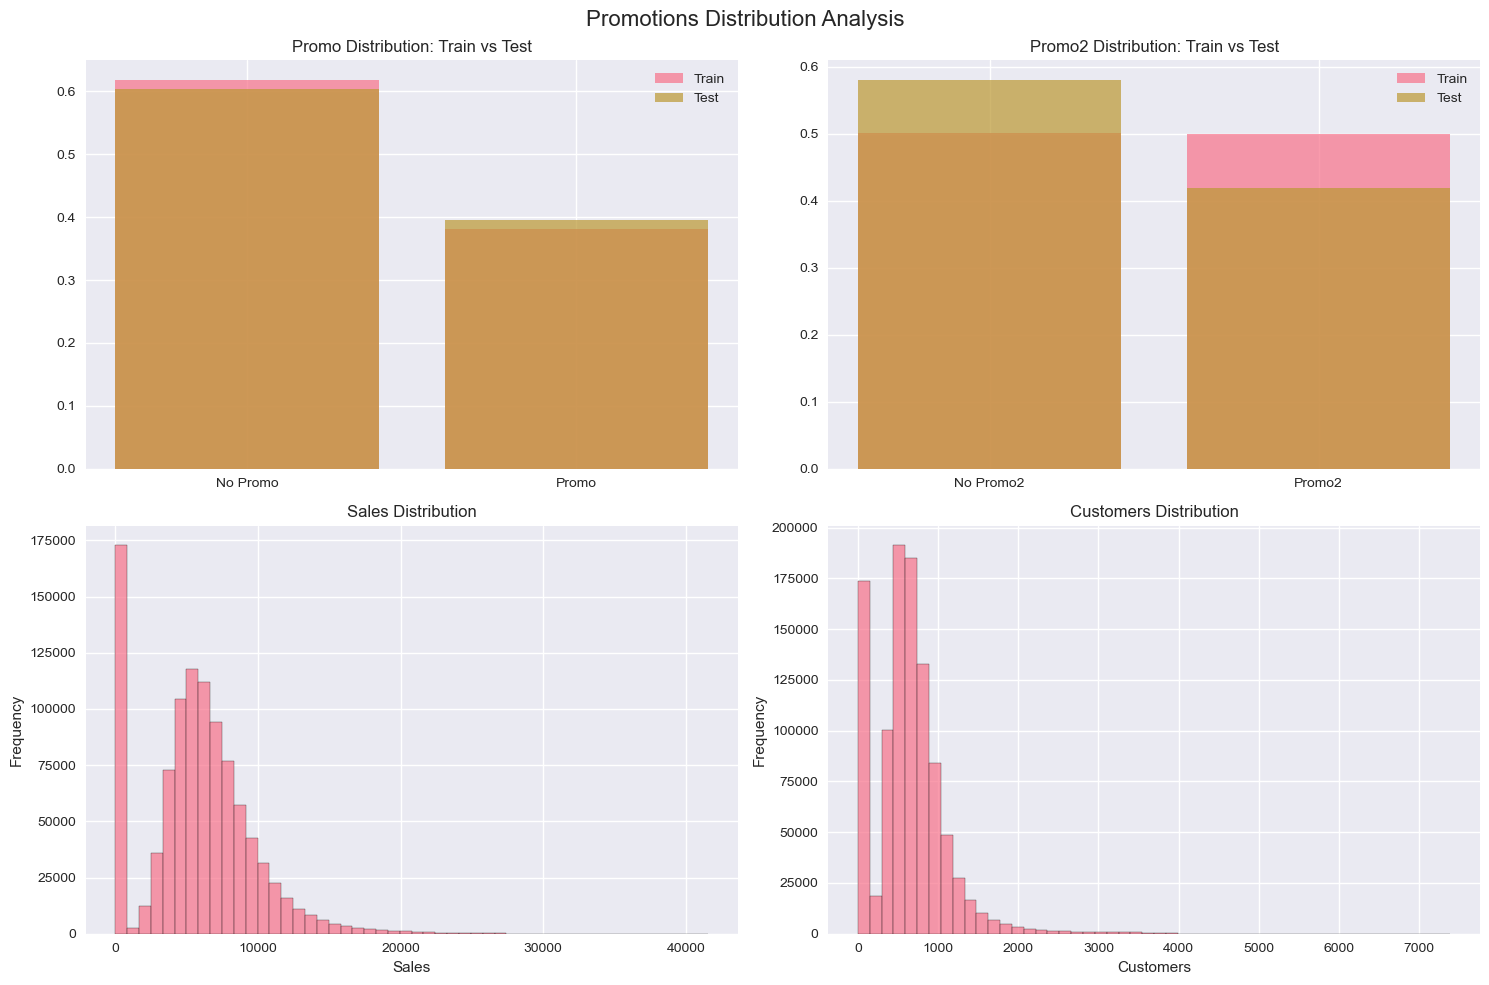

In [33]:
# 1. Distribution Analysis
logger.info("Analyzing promotions distribution")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Promotions Distribution Analysis', fontsize=16)

# Promo distribution in train vs test
train_promo = train_merged['Promo'].value_counts(normalize=True)
test_promo = test_merged['Promo'].value_counts(normalize=True)

axes[0,0].bar(['No Promo', 'Promo'], train_promo.values, alpha=0.7, label='Train')
axes[0,0].bar(['No Promo', 'Promo'], test_promo.values, alpha=0.7, label='Test')
axes[0,0].set_title('Promo Distribution: Train vs Test')
axes[0,0].legend()
# Promo2 distribution
train_promo2 = train_merged['Promo2'].value_counts(normalize=True)
test_promo2 = test_merged['Promo2'].value_counts(normalize=True)

axes[0,1].bar(['No Promo2', 'Promo2'], train_promo2.values, alpha=0.7, label='Train')
axes[0,1].bar(['No Promo2', 'Promo2'], test_promo2.values, alpha=0.7, label='Test')
axes[0,1].set_title('Promo2 Distribution: Train vs Test')
axes[0,1].legend()

# Sales distribution
axes[1,0].hist(train_merged['Sales'], bins=50, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Sales Distribution')
axes[1,0].set_xlabel('Sales')
axes[1,0].set_ylabel('Frequency')

# Customers distribution
axes[1,1].hist(train_merged['Customers'], bins=50, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Customers Distribution')
axes[1,1].set_xlabel('Customers')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

2025-06-24 13:39:36,606 - INFO - Analyzing sales behavior around holidays
2025-06-24 13:39:36,857 - INFO - Analyzing sales behavior around holidays
2025-06-24 13:39:37,255 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-24 13:39:37,258 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


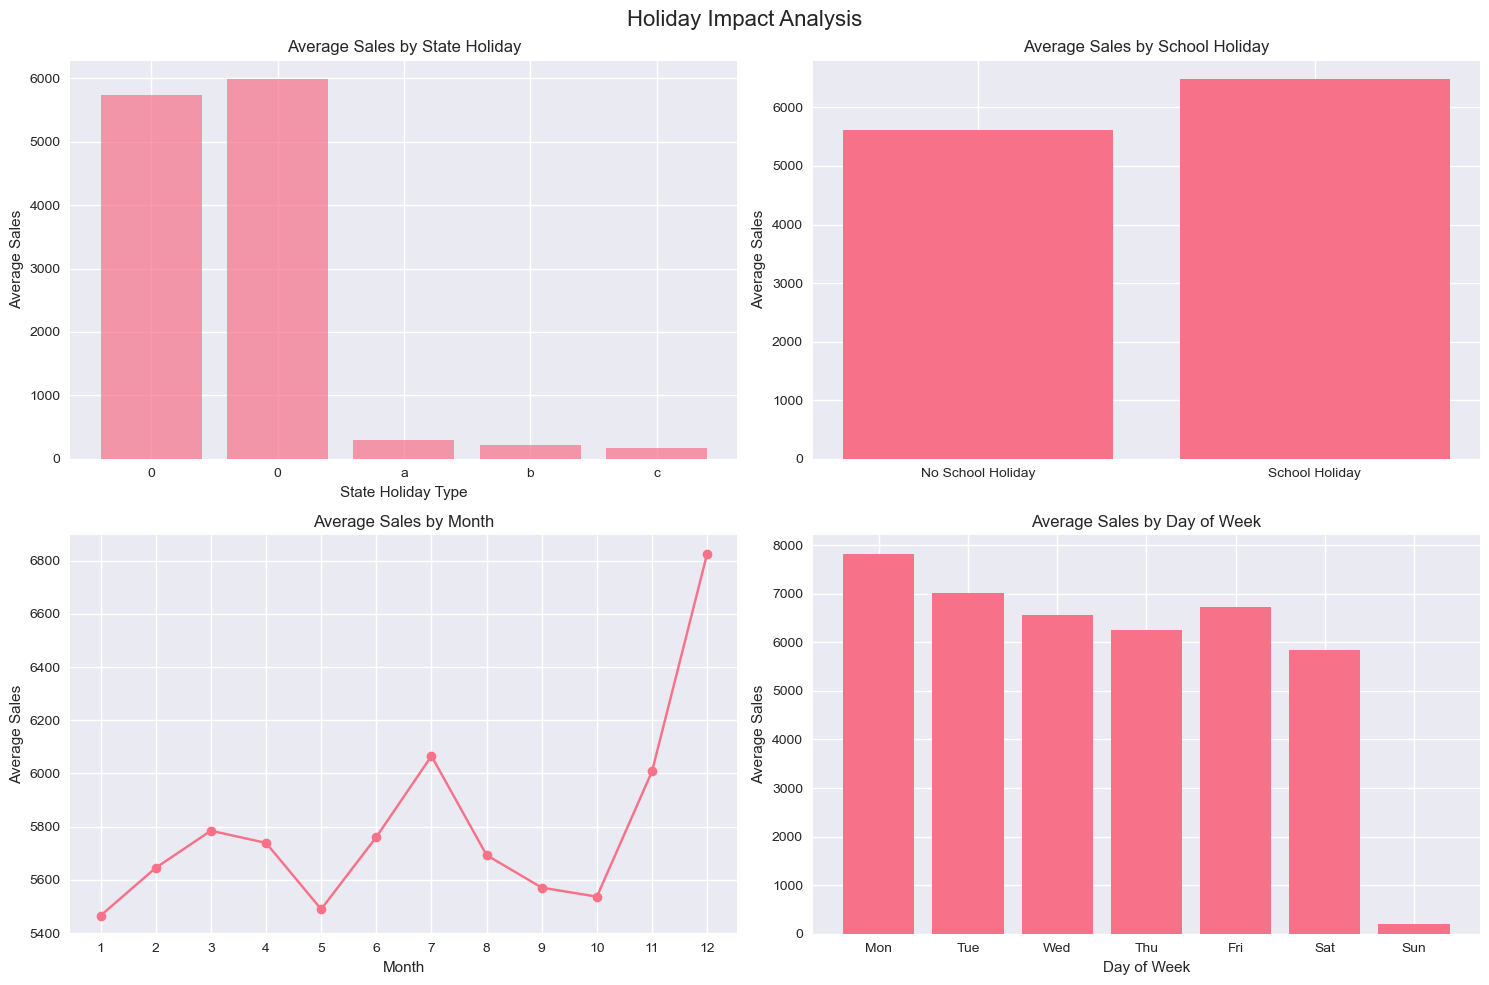

In [39]:
# 2. Holiday Analysis
logger.info("Analyzing sales behavior around holidays")

# Create holiday periods
train_merged['IsHoliday'] = train_merged['StateHoliday'] != '0'
train_merged['IsSchoolHoliday'] = train_merged['SchoolHoliday'] == 1

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Holiday Impact Analysis', fontsize=16)

# State holidays impact
logger.info("Analyzing sales behavior around holidays")

holiday_sales = train_merged.groupby('StateHoliday')['Sales'].mean()

# Convert string labels to numeric x-axis positions
x_pos = range(len(holiday_sales))

# Plot using numeric positions
axes[0,0].bar(x_pos, holiday_sales.values, alpha=0.7)

# Set string labels manually
axes[0,0].set_xticks(x_pos)
axes[0,0].set_xticklabels(holiday_sales.index)

axes[0,0].set_title('Average Sales by State Holiday')
axes[0,0].set_xlabel('State Holiday Type')
axes[0,0].set_ylabel('Average Sales')


# School holidays impact
school_holiday_sales = train_merged.groupby('SchoolHoliday')['Sales'].mean()
axes[0,1].bar(['No School Holiday', 'School Holiday'], school_holiday_sales.values)
axes[0,1].set_title('Average Sales by School Holiday')
axes[0,1].set_ylabel('Average Sales')

# Monthly sales pattern
monthly_sales = train_merged.groupby('Month')['Sales'].mean()
axes[1,0].plot(monthly_sales.index, monthly_sales.values, marker='o')
axes[1,0].set_title('Average Sales by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Sales')
axes[1,0].set_xticks(range(1, 13))

# Day of week pattern
dow_sales = train_merged.groupby('DayOfWeek')['Sales'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(days, dow_sales.values)
axes[1,1].set_title('Average Sales by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

2025-06-24 13:40:25,331 - INFO - Analyzing seasonal purchase behaviors


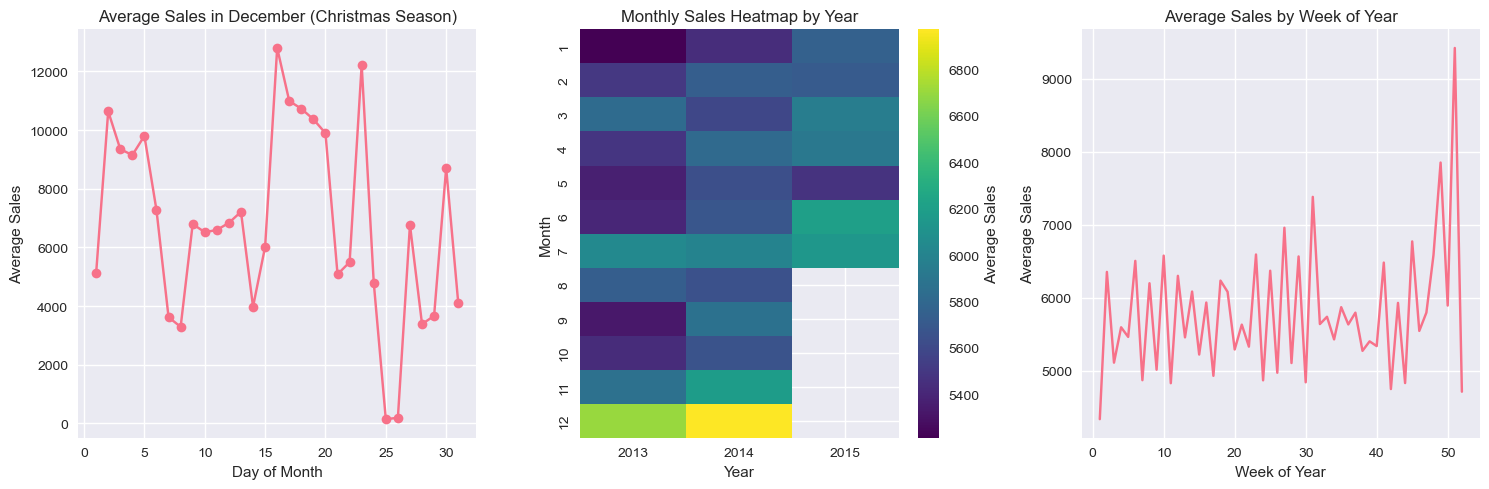

In [41]:
# 3. Seasonal Analysis
logger.info("Analyzing seasonal purchase behaviors")

# Christmas analysis (December)
christmas_data = train_merged[train_merged['Month'] == 12]
christmas_sales = christmas_data.groupby('Day')['Sales'].mean()

# Easter analysis (varies by year, but typically March/April)
easter_months = train_merged[train_merged['Month'].isin([3, 4])]
easter_sales = easter_months.groupby(['Month', 'Day'])['Sales'].mean()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(christmas_sales.index, christmas_sales.values, marker='o')
plt.title('Average Sales in December (Christmas Season)')
plt.xlabel('Day of Month')
plt.ylabel('Average Sales')

plt.subplot(1, 3, 2)
yearly_sales = train_merged.groupby(['Year', 'Month'])['Sales'].mean().unstack()
sns.heatmap(yearly_sales.T, cmap='viridis', cbar_kws={'label': 'Average Sales'})
plt.title('Monthly Sales Heatmap by Year')
plt.xlabel('Year')
plt.ylabel('Month')

plt.subplot(1, 3, 3)
weekly_sales = train_merged.groupby('WeekOfYear')['Sales'].mean()
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Average Sales by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Sales')

plt.tight_layout()
plt.show()

2025-06-24 13:41:03,037 - INFO - Analyzing correlation between sales and customers


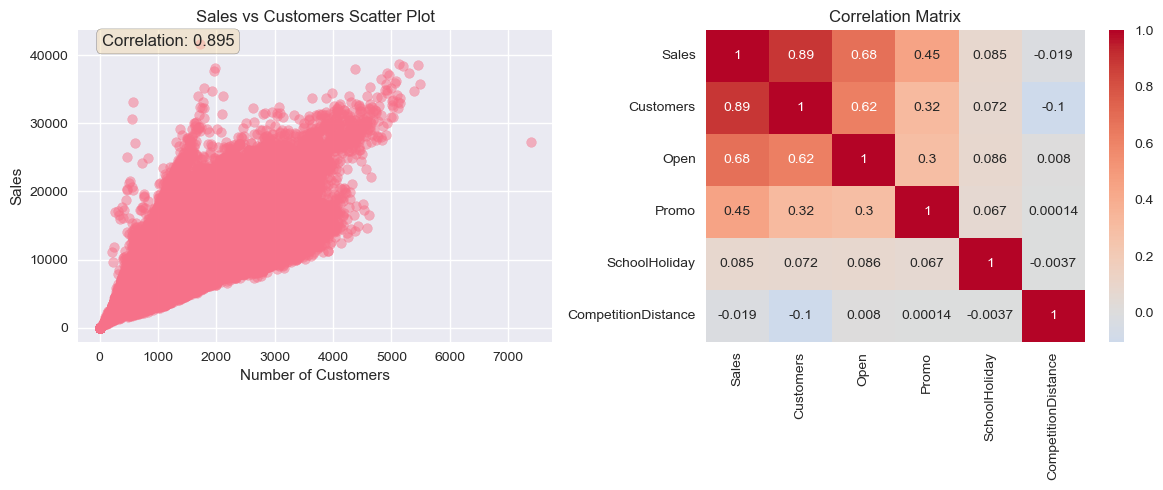

Sales-Customers Correlation: 0.895


In [43]:
# 4. Sales vs Customers Correlation
logger.info("Analyzing correlation between sales and customers")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(train_merged['Customers'], train_merged['Sales'], alpha=0.5)
plt.xlabel('Number of Customers')
plt.ylabel('Sales')
plt.title('Sales vs Customers Scatter Plot')

# Calculate correlation
correlation = train_merged['Sales'].corr(train_merged['Customers'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.subplot(1, 2, 2)
# Correlation matrix
corr_cols = ['Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance']
corr_matrix = train_merged[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

print(f"Sales-Customers Correlation: {correlation:.3f}")


2025-06-24 13:41:38,484 - INFO - Analyzing promo effectiveness


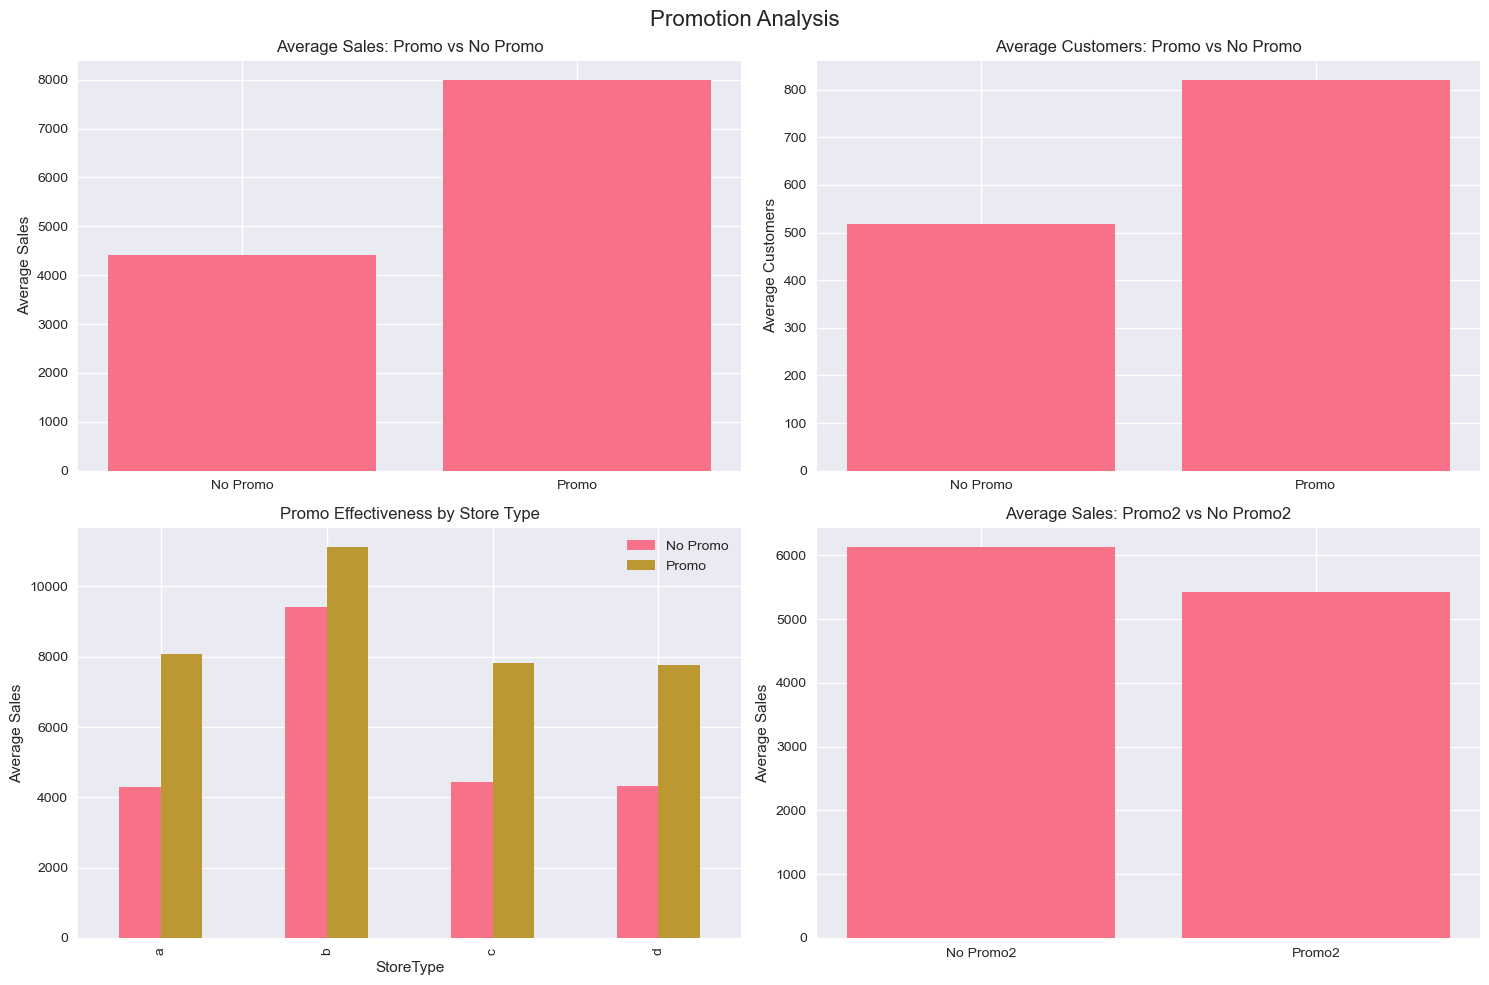

In [45]:
# 5. Promo Analysis
logger.info("Analyzing promo effectiveness")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Promotion Analysis', fontsize=16)

# Promo impact on sales
promo_sales = train_merged.groupby('Promo')['Sales'].mean()
axes[0,0].bar(['No Promo', 'Promo'], promo_sales.values)
axes[0,0].set_title('Average Sales: Promo vs No Promo')
axes[0,0].set_ylabel('Average Sales')

# Promo impact on customers
promo_customers = train_merged.groupby('Promo')['Customers'].mean()
axes[0,1].bar(['No Promo', 'Promo'], promo_customers.values)
axes[0,1].set_title('Average Customers: Promo vs No Promo')
axes[0,1].set_ylabel('Average Customers')

# Promo effectiveness by store type
promo_store_sales = train_merged.groupby(['StoreType', 'Promo'])['Sales'].mean().unstack()
promo_store_sales.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Promo Effectiveness by Store Type')
axes[1,0].set_ylabel('Average Sales')
axes[1,0].legend(['No Promo', 'Promo'])

# Promo2 analysis
promo2_sales = train_merged.groupby('Promo2')['Sales'].mean()
axes[1,1].bar(['No Promo2', 'Promo2'], promo2_sales.values)
axes[1,1].set_title('Average Sales: Promo2 vs No Promo2')
axes[1,1].set_ylabel('Average Sales')

plt.tight_layout()
plt.show()

2025-06-24 13:42:01,932 - INFO - Analyzing store characteristics


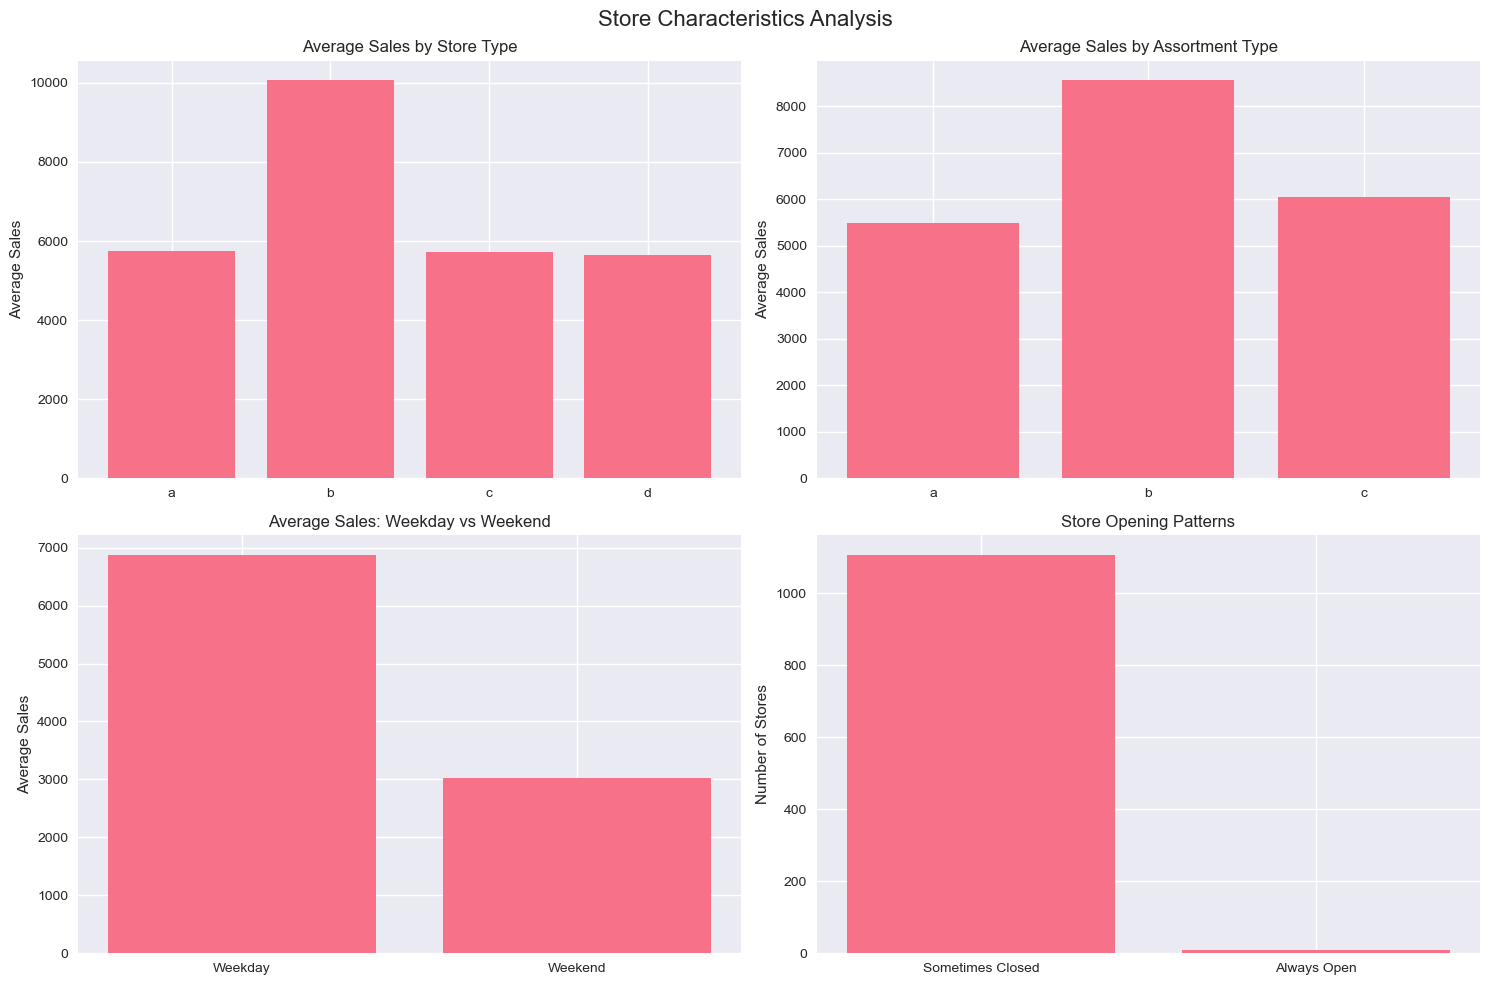

In [47]:
# 6. Store Analysis
logger.info("Analyzing store characteristics")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Store Characteristics Analysis', fontsize=16)

# Store type analysis
storetype_sales = train_merged.groupby('StoreType')['Sales'].mean()
axes[0,0].bar(storetype_sales.index, storetype_sales.values)
axes[0,0].set_title('Average Sales by Store Type')
axes[0,0].set_ylabel('Average Sales')

# Assortment analysis
assortment_sales = train_merged.groupby('Assortment')['Sales'].mean()
axes[0,1].bar(assortment_sales.index, assortment_sales.values)
axes[0,1].set_title('Average Sales by Assortment Type')
axes[0,1].set_ylabel('Average Sales')

# Weekend analysis
weekend_sales = train_merged.groupby(train_merged['DayOfWeek'].isin([5, 6]))['Sales'].mean()
axes[1,0].bar(['Weekday', 'Weekend'], weekend_sales.values)
axes[1,0].set_title('Average Sales: Weekday vs Weekend')
axes[1,0].set_ylabel('Average Sales')

# Open stores analysis
open_analysis = train_merged.groupby(['Store', 'DayOfWeek'])['Open'].mean()
always_open_stores = open_analysis.groupby('Store').min()
always_open_count = (always_open_stores == 1).sum()
axes[1,1].bar(['Sometimes Closed', 'Always Open'], 
              [len(always_open_stores) - always_open_count, always_open_count])
axes[1,1].set_title('Store Opening Patterns')
axes[1,1].set_ylabel('Number of Stores')

plt.tight_layout()
plt.show()


2025-06-24 13:42:25,493 - INFO - Analyzing competition impact


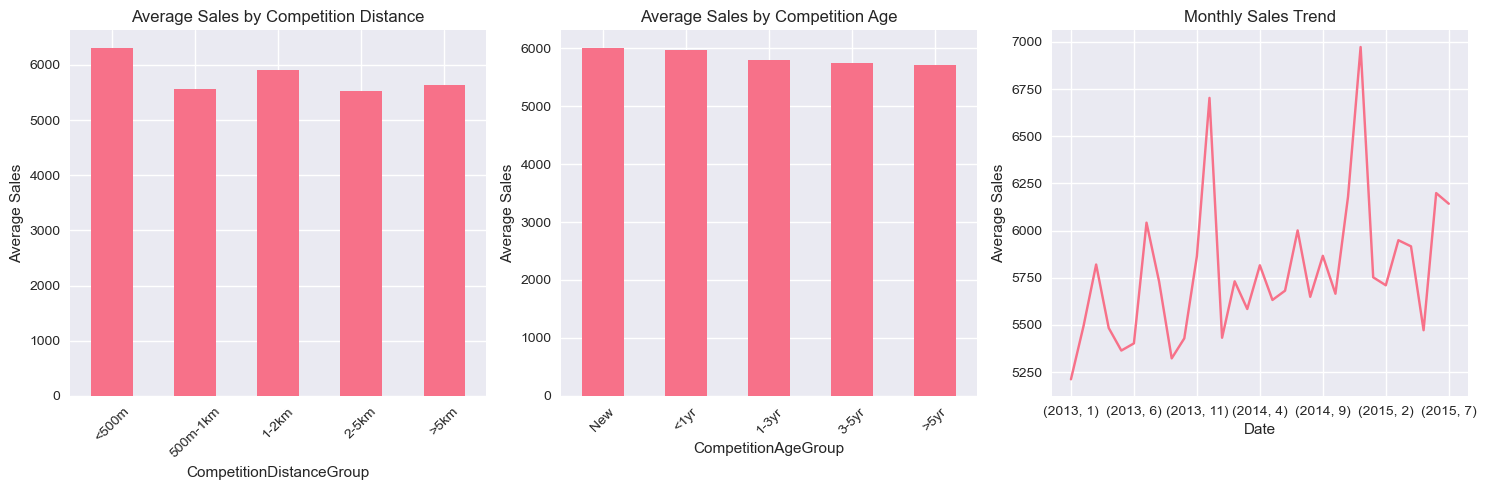

In [49]:
# 7. Competition Analysis
logger.info("Analyzing competition impact")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# Competition distance impact
train_merged['CompetitionDistanceGroup'] = pd.cut(train_merged['CompetitionDistance'], 
                                                  bins=[0, 500, 1000, 2000, 5000, np.inf], 
                                                  labels=['<500m', '500m-1km', '1-2km', '2-5km', '>5km'])
comp_dist_sales = train_merged.groupby('CompetitionDistanceGroup')['Sales'].mean()
comp_dist_sales.plot(kind='bar')
plt.title('Average Sales by Competition Distance')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
# New competition impact
train_merged['CompetitionAge'] = train_merged['Year'] - train_merged['CompetitionOpenSinceYear']
train_merged['CompetitionAge'] = train_merged['CompetitionAge'].clip(lower=0)
train_merged['CompetitionAgeGroup'] = pd.cut(train_merged['CompetitionAge'], 
                                             bins=[-1, 0, 1, 3, 5, np.inf], 
                                             labels=['New', '<1yr', '1-3yr', '3-5yr', '>5yr'])
comp_age_sales = train_merged.groupby('CompetitionAgeGroup')['Sales'].mean()
comp_age_sales.plot(kind='bar')
plt.title('Average Sales by Competition Age')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Sales trend over time
monthly_trend = train_merged.groupby(['Year', 'Month'])['Sales'].mean()
monthly_trend.plot()
plt.title('Monthly Sales Trend')
plt.ylabel('Average Sales')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


In [51]:
# Summary Statistics
logger.info("Summary statistics")

print("\n=== KEY FINDINGS SUMMARY ===")
print(f"1. Sales-Customers Correlation: {correlation:.3f} (Strong positive correlation)")
print(f"2. Promo Impact: {(promo_sales[1]/promo_sales[0]-1)*100:.1f}% increase in sales")
print(f"3. Promo2 Impact: {(promo2_sales[1]/promo2_sales[0]-1)*100:.1f}% increase in sales")
print(f"4. Best performing store type: {storetype_sales.idxmax()} (Avg: {storetype_sales.max():.0f})")
print(f"5. Best assortment type: {assortment_sales.idxmax()} (Avg: {assortment_sales.max():.0f})")
print(f"6. Weekend vs Weekday: {(weekend_sales[True]/weekend_sales[False]-1)*100:.1f}% difference")


2025-06-24 13:42:53,948 - INFO - Summary statistics



=== KEY FINDINGS SUMMARY ===
1. Sales-Customers Correlation: 0.895 (Strong positive correlation)
2. Promo Impact: 81.4% increase in sales
3. Promo2 Impact: -11.4% increase in sales
4. Best performing store type: b (Avg: 10061)
5. Best assortment type: b (Avg: 8557)
6. Weekend vs Weekday: -55.9% difference


In [53]:
# Store recommendations for promos
store_promo_effectiveness = train_merged.groupby(['Store', 'Promo'])['Sales'].mean().unstack()
store_promo_effectiveness['PromoLift'] = (store_promo_effectiveness[1] / store_promo_effectiveness[0] - 1) * 100
top_promo_stores = store_promo_effectiveness['PromoLift'].nlargest(10)


In [55]:
print(f"\n=== TOP 10 STORES FOR PROMO DEPLOYMENT ===")
for store, lift in top_promo_stores.items():
    print(f"Store {store}: {lift:.1f}% sales increase with promos")

logger.info("Exploratory Data Analysis completed successfully")

2025-06-24 13:43:23,038 - INFO - Exploratory Data Analysis completed successfully



=== TOP 10 STORES FOR PROMO DEPLOYMENT ===
Store 198: 225.8% sales increase with promos
Store 607: 189.0% sales increase with promos
Store 543: 175.9% sales increase with promos
Store 575: 173.7% sales increase with promos
Store 271: 162.0% sales increase with promos
Store 693: 161.2% sales increase with promos
Store 96: 157.5% sales increase with promos
Store 1108: 156.7% sales increase with promos
Store 552: 156.3% sales increase with promos
Store 635: 156.0% sales increase with promos


In [57]:
# Save cleaned data
train_merged.to_csv('cleaned_data/train_cleaned.csv', index=False)
logger.info("Cleaned data saved to train_cleaned.csv")

2025-06-24 13:44:36,107 - INFO - Cleaned data saved to train_cleaned.csv
